In [73]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [74]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [75]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
STM_t0 = np.zeros((24, 24, T + 1))
STM_t0[:, :, 0] = np.eye(24)
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])
    STM_t0[:, :, t + 1] = SatelliteDynamics().Phi(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [76]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def H_jacobian_chief():
    """
    Computes the Jacobian of the measurement function.
    """
    H = np.zeros((3, 24))
    H[0:3, 0:3] = np.eye(3)
    return H

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def H_jacobian_deputy(x_vec):
    """
    Computes the Jacobian of the measurement function.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    H (np.array): The Jacobian of the measurement function.
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    H = np.zeros((6, 24))
    H[0, 0:3] = -(r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[0, 6:9] = (r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[1, 6:9] = (r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[1, 12:15] = -(r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[2, 6:9] = (r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[2, 18:21] = -(r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[3, 0:3] = -(r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[3, 12:15] = (r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[4, 12:15] = (r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[4, 18:21] = -(r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[5, 0:3] = -(r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    H[5, 18:21] = (r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    return H

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

def H(x):
    return np.concatenate((H_jacobian_chief(), H_jacobian_deputy(x)))

In [77]:
# Simulation setup
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [78]:
def f(x_0, STM, y):
    f_x_0 = 0

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_0 = x_0[:n_x, :]
    x_2_0 = x_0[n_x:2*n_x, :]
    x_3_0 = x_0[2*n_x:3*n_x, :]
    x_4_0 = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
        x_1_k = STM[:n_x, :n_x, k] @ x_1_0
        x_2_k = STM[n_x:2*n_x, n_x:2*n_x, k] @ x_2_0
        x_3_k = STM[2*n_x:3*n_x, 2*n_x:3*n_x, k] @ x_3_0
        x_4_k = STM[3*n_x:4*n_x, 3*n_x:4*n_x, k] @ x_4_0
        
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

    return f_x_0

def grad_f(x_0, STM, y):
    grad_f_x_0 = np.zeros_like(x_0)

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_0 = x_0[:n_x, :]
    x_2_0 = x_0[n_x:2*n_x, :]
    x_3_0 = x_0[2*n_x:3*n_x, :]
    x_4_0 = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
        x_1_k = STM[:n_x, :n_x, k] @ x_1_0
        x_2_k = STM[n_x:2*n_x, n_x:2*n_x, k] @ x_2_0
        x_3_k = STM[2*n_x:3*n_x, 2*n_x:3*n_x, k] @ x_3_0
        x_4_k = STM[3*n_x:4*n_x, 3*n_x:4*n_x, k] @ x_4_0
        
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_f_x_0[:n_x, :] -= STM[:n_x, :n_x, k].T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_f_x_0[(i - 1) * n_x:i * n_x, :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM[(i - 1)*n_x:i*n_x, (i - 1)*n_x:i*n_x, k].T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_f_x_0[(j - 1) * n_x:j * n_x, :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM[(j - 1)*n_x:j*n_x, (j - 1)*n_x:j*n_x, k].T @ P.T @ d_ij_k_vec) / d_ij_k

    return grad_f_x_0

def hessian_f(x_0, STM, y):
    hessian_f_x_0 = np.zeros((x_0.shape[0], x_0.shape[0]))  # Initialize Hessian matrix
    
    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_0 = x_0[:n_x, :]
    x_2_0 = x_0[n_x:2*n_x, :]
    x_3_0 = x_0[2*n_x:3*n_x, :]
    x_4_0 = x_0[3*n_x:4*n_x, :]

    # Iterate over all sliding window time steps
    for k in range(W):
        # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
        x_1_k = STM[:n_x, :n_x, k] @ x_1_0
        x_2_k = STM[n_x:2*n_x, n_x:2*n_x, k] @ x_2_0
        x_3_k = STM[2*n_x:3*n_x, 2*n_x:3*n_x, k] @ x_3_0
        x_4_k = STM[3*n_x:4*n_x, 3*n_x:4*n_x, k] @ x_4_0

        # Absolute residual term: observed data y for each state
        y_rel_k = y[n_y_1:, :, k]

        # Absolute measurement residuals' Hessian
        hessian_f_x_0[:n_x, :n_x] += STM[:n_x, :n_x, k].T @ P.T @ np.linalg.inv(R_chief) @ P @ STM[:n_x, :n_x, k] 

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM[idx_i:idx_i + n_x, idx_i:idx_i + n_x, k].T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM[idx_i:idx_i + n_x, idx_i:idx_i + n_x, k])
            hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM[idx_i:idx_i + n_x, idx_i:idx_i + n_x, k].T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM[idx_j:idx_j + n_x, idx_j:idx_j + n_x, k])
            hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM[idx_j:idx_j + n_x, idx_j:idx_j + n_x, k].T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM[idx_i:idx_i + n_x, idx_i:idx_i + n_x, k])
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM[idx_j:idx_j + n_x, idx_j:idx_j + n_x, k].T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM[idx_j:idx_j + n_x, idx_j:idx_j + n_x, k])

    return hessian_f_x_0

In [79]:
def L(x_0, STM, y):
    return f(x_0, STM, y)
    
def grad_L(x_0, STM, y):
    return grad_f(x_0, STM, y)

def hessian_L(x_0, STM, y):
    return hessian_f(x_0, STM, y)

In [80]:
class NKKT:
    def __init__(self, tolerance=1e0, max_iter=100):
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.i = None
        
        # Storage for results
        self.L_norms = []
        self.grad_L_norms = []

    def solve(self, x_init, STM, Y):
        x = x_init
        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            L_x = L(x, STM, Y)
            grad_L_x = grad_L(x, STM, Y)
            hessian_L_x = hessian_L(x, STM, Y)

            # Calculate norms for convergence tracking
            L_norm = np.linalg.norm(L_x)
            grad_L_norm = np.linalg.norm(grad_L_x)

            # Store the norms
            self.L_norms.append(L_norm)
            self.grad_L_norms.append(grad_L_norm)

            # Check convergence and print metrics
            if grad_L_norm < self.tolerance or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                else:
                    print(f"Iteration {iteration}\nL_norm = {L_norm}\nGrad_L_norm = {grad_L_norm}\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(hessian_L_x, -grad_L_x)
            x += delta_x
        
            # Save the current iteration
            self.i = iteration + 1

        return x

In [81]:
def give_me_the_plots(i, L_norms, grad_L_norms):
    iterations = np.arange(0, i + 1)

    # Plot 1
    plt.semilogy(iterations, L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||L(x^{(m)})||_2$')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_L_norms, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.show()

------------------------------------ Monte Carlo run #1 ------------------------------------
Before applying the algorithm
L_norm = 4.54314756431766e+17
Grad_L_norm = 3954433106287.545

Iteration 1
L_norm = 2.351756382539756e+17
Grad_L_norm = 183124565.5451429

Iteration 2
L_norm = 2.3517632893624058e+17
Grad_L_norm = 1440758146.7443354

Iteration 3
L_norm = 2.3517560004140845e+17
Grad_L_norm = 14373068.459569376

Iteration 4
L_norm = 2.3517560000660486e+17
Grad_L_norm = 7778282.7323671365

Iteration 5
L_norm = 2.3517560086078058e+17
Grad_L_norm = 38501047.49000239

Iteration 6
L_norm = 2.3517560003406608e+17
Grad_L_norm = 10245559.681519482

Iteration 7
L_norm = 2.351756000112302e+17
Grad_L_norm = 11521473.356079007

Iteration 8
L_norm = 2.3517560004987866e+17
Grad_L_norm = 15409797.756091738

Iteration 9
L_norm = 2.3517559995405283e+17
Grad_L_norm = 2441783.7310631014

Iteration 10
L_norm = 2.351756001630447e+17
Grad_L_norm = 23848948.52767899

Iteration 11
L_norm = 2.351755999479868

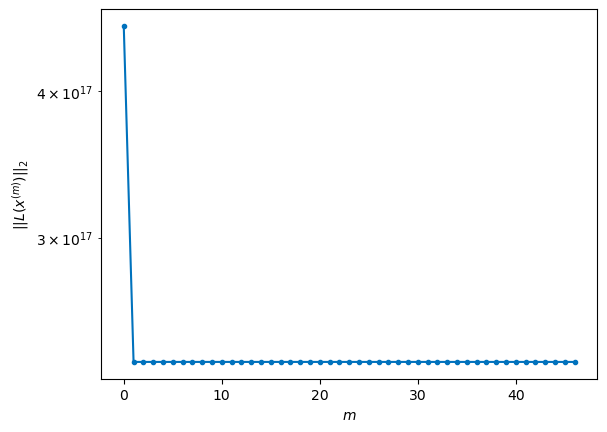

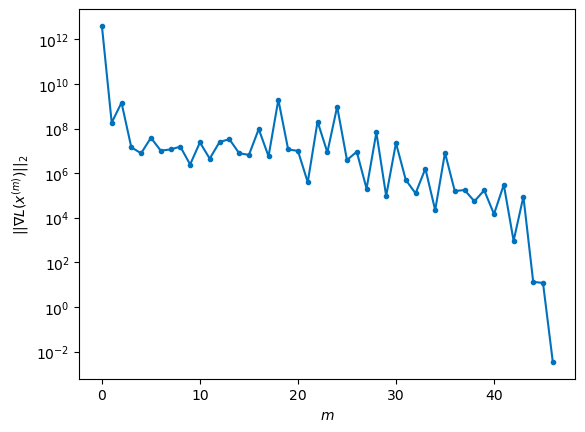

Before applying the algorithm
L_norm = 2.931220233898388e+26
Grad_L_norm = 1.451606090054818e+17

Iteration 1
L_norm = 2.366758760299731e+17
Grad_L_norm = 227772268.8392211



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.67661e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19954e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3667584781056234e+17
Grad_L_norm = 17432678.6625219

Iteration 3
L_norm = 2.3667584749929498e+17
Grad_L_norm = 1727242.509853741



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.43357e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.44104e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
L_norm = 2.3667584749487555e+17
Grad_L_norm = 58317.861683459814

Iteration 5
L_norm = 2.366758474948647e+17
Grad_L_norm = 103.72095515396498



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.44159e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.44181e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


STOP on Iteration 6
L_norm = 2.3667584749487443e+17
Grad_L_norm = 0.32127161257311526



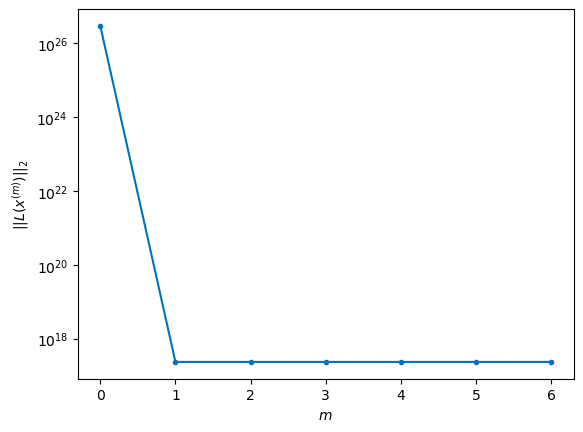

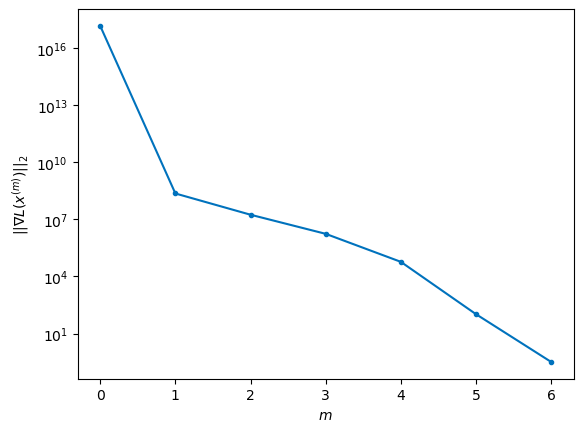

Before applying the algorithm
L_norm = 1.2627148632305626e+25
Grad_L_norm = 3.037916803143504e+16

Iteration 1
L_norm = 2.3647303620871184e+17
Grad_L_norm = 298215041.1187241



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.63399e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.4823e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3647299994994778e+17
Grad_L_norm = 16588275.334311912

Iteration 3
L_norm = 2.364729997178389e+17
Grad_L_norm = 518180.5560976912



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.42792e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.42253e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
L_norm = 2.364729997176013e+17
Grad_L_norm = 978.5771137384364

Iteration 5
L_norm = 2.3647299971760992e+17
Grad_L_norm = 1.5298604704292067



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.42246e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.42193e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


STOP on Iteration 6
L_norm = 2.3647299971760246e+17
Grad_L_norm = 0.5992251250632891



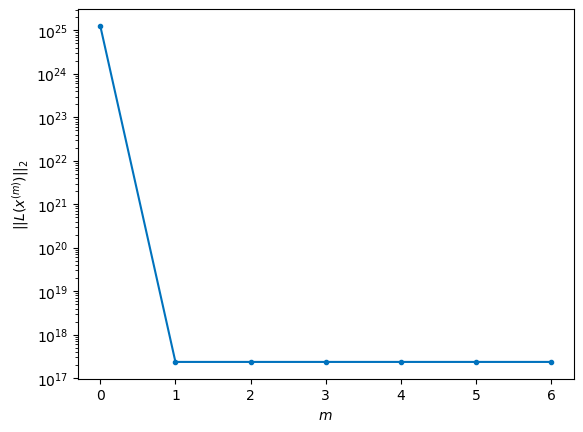

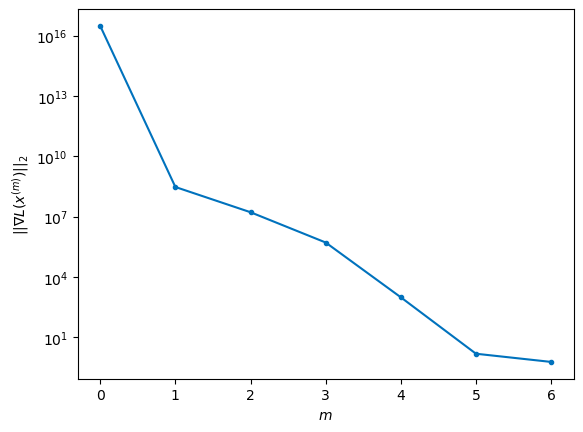

Before applying the algorithm
L_norm = 2.689075144215344e+25
Grad_L_norm = 4.434125321691399e+16

Iteration 1
L_norm = 2.3619488162028563e+17
Grad_L_norm = 307100151.497221



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.58743e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.44289e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3619484398346163e+17
Grad_L_norm = 8442430.420462318



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39557e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 3
L_norm = 2.361948439141756e+17
Grad_L_norm = 174812.6694338186

Iteration 4
L_norm = 2.3619484391413117e+17
Grad_L_norm = 171.75839236886512



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39379e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39398e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 5
L_norm = 2.3619484391414186e+17
Grad_L_norm = 7.830569273130816

Iteration 6
L_norm = 2.3619484391412118e+17
Grad_L_norm = 2.220716016914136



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39278e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39348e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 7
L_norm = 2.361948439141271e+17
Grad_L_norm = 1.0673285760328974

STOP on Iteration 8
L_norm = 2.361948439141224e+17
Grad_L_norm = 0.4326917989518971



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39412e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


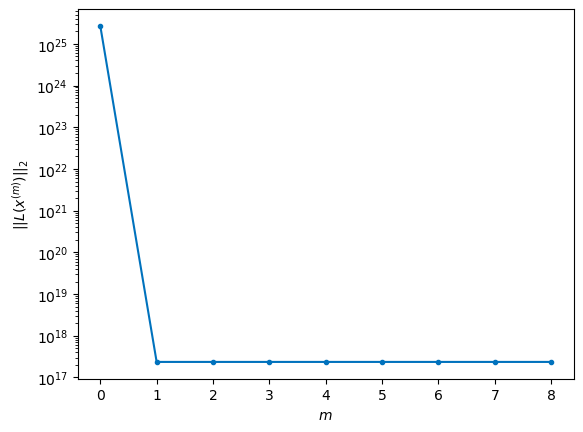

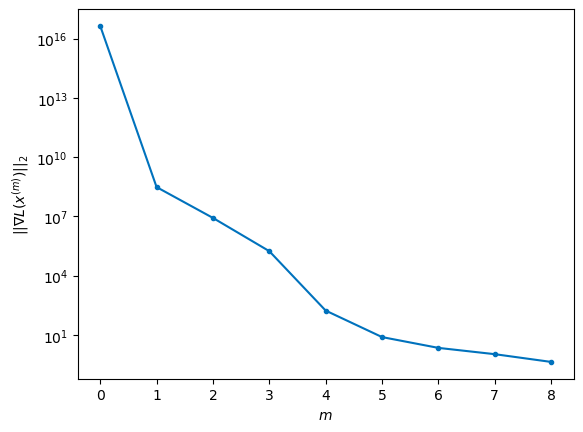

Before applying the algorithm
L_norm = 4.687613830403968e+25
Grad_L_norm = 5.8552216454627576e+16

Iteration 1
L_norm = 2.3584153025539555e+17
Grad_L_norm = 312940258.5164867



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.5382e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.39589e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3584149153426464e+17
Grad_L_norm = 6689608.227759273



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.35619e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 3
L_norm = 2.358414915083797e+17
Grad_L_norm = 19376.287075212484

STOP on Iteration 4
L_norm = 2.3584149150836656e+17
Grad_L_norm = 0.6956796352077701



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.35386e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


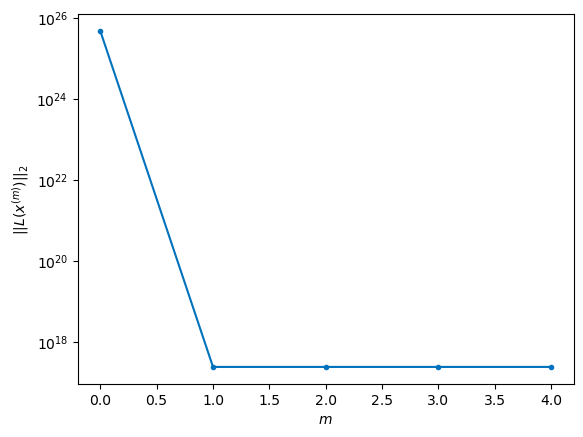

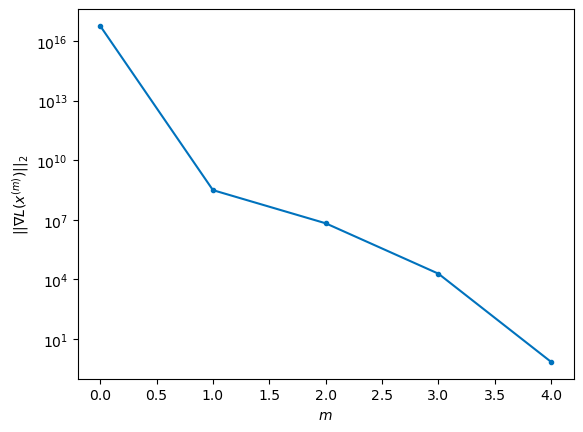

Before applying the algorithm
L_norm = 7.293239871825313e+25
Grad_L_norm = 7.304368170710542e+16

Iteration 1
L_norm = 2.3541411993005693e+17
Grad_L_norm = 317410256.1009709



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.48869e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.34621e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.354140801677304e+17
Grad_L_norm = 5914831.964062283



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31334e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 3
L_norm = 2.3541408015122614e+17
Grad_L_norm = 3611.587688201166



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31105e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
L_norm = 2.3541408015121104e+17
Grad_L_norm = 4.356899165852876



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31128e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 5
L_norm = 2.3541408015121725e+17
Grad_L_norm = 5.17465899707836

Iteration 6
L_norm = 2.3541408015122877e+17
Grad_L_norm = 3.8916027448386457

Iteration 7
L_norm = 2.35414080151222e+17
Grad_L_norm = 1.5318292670981757



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31171e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31226e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 8
L_norm = 2.354140801511869e+17
Grad_L_norm = 16.327092115315384

Iteration 9
L_norm = 2.3541408015122048e+17
Grad_L_norm = 12.681742648829065



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31154e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31214e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 10
L_norm = 2.3541408015124858e+17
Grad_L_norm = 10.658341631178356

Iteration 11
L_norm = 2.354140801512116e+17
Grad_L_norm = 2.249169725217457



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31182e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31107e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 12
L_norm = 2.354140801512277e+17
Grad_L_norm = 11.218587841225306



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31174e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 13
L_norm = 2.354140801511965e+17
Grad_L_norm = 3.256898126940251

Iteration 14
L_norm = 2.354140801512406e+17
Grad_L_norm = 1.7152073557006948



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31103e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31124e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 15
L_norm = 2.3541408015123414e+17
Grad_L_norm = 11.837015114083812

Iteration 16
L_norm = 2.354140801512126e+17
Grad_L_norm = 2.3012308717855356



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31189e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31196e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 17
L_norm = 2.3541408015119258e+17
Grad_L_norm = 4.616432853963805

Iteration 18
L_norm = 2.3541408015121146e+17
Grad_L_norm = 9.993298655742356



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31098e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31133e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 19
L_norm = 2.3541408015121258e+17
Grad_L_norm = 1.1093913733687673

Iteration 20
L_norm = 2.3541408015121587e+17
Grad_L_norm = 14.67363289756425



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31072e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31198e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 21
L_norm = 2.3541408015122358e+17
Grad_L_norm = 6.050209352881594

Iteration 22
L_norm = 2.3541408015122582e+17
Grad_L_norm = 9.572489471273162



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.3113e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.31175e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 23
L_norm = 2.3541408015119594e+17
Grad_L_norm = 12.04337079291972

STOP on Iteration 24
L_norm = 2.3541408015122675e+17
Grad_L_norm = 0.9224055355379559



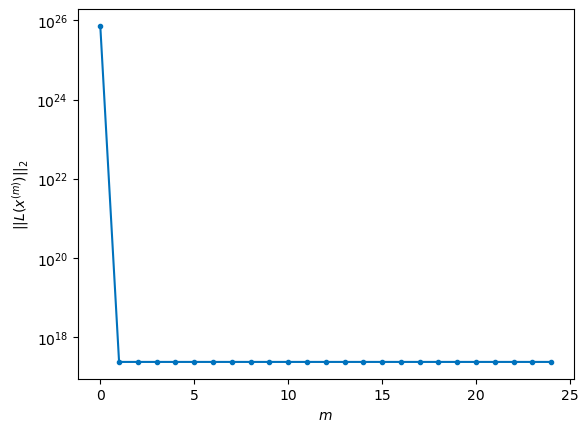

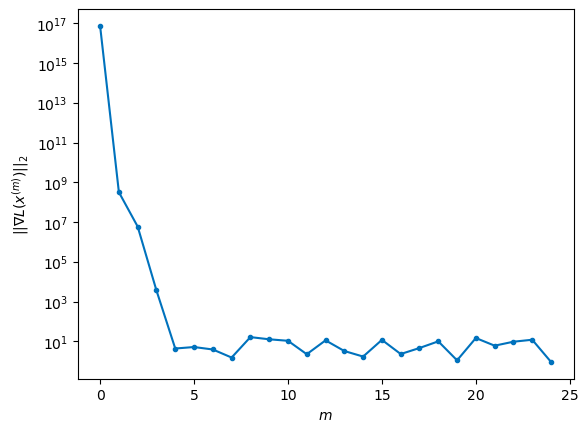

Before applying the algorithm
L_norm = 1.0537343438926413e+26
Grad_L_norm = 8.780953925420054e+16



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.44387e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 1
L_norm = 2.34915451505046e+17
Grad_L_norm = 321678647.4156165

Iteration 2
L_norm = 2.3491541093432717e+17
Grad_L_norm = 5936744.965832075



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.29474e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2685e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 3
L_norm = 2.3491541090917216e+17
Grad_L_norm = 7459.6522196724045

Iteration 4
L_norm = 2.3491541090919968e+17
Grad_L_norm = 7.954397598697545



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26726e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26704e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 5
L_norm = 2.3491541090918445e+17
Grad_L_norm = 6.961272772331369

Iteration 6
L_norm = 2.349154109091805e+17
Grad_L_norm = 3.383994469736797



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2673e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26721e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 7
L_norm = 2.3491541090916006e+17
Grad_L_norm = 2.6831197897379884

Iteration 8
L_norm = 2.349154109091829e+17
Grad_L_norm = 12.591066933728298



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26707e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26767e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 9
L_norm = 2.3491541090912634e+17
Grad_L_norm = 8.685359396159972

Iteration 10
L_norm = 2.349154109091743e+17
Grad_L_norm = 11.769464474794049



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26754e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26695e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 11
L_norm = 2.3491541090920506e+17
Grad_L_norm = 8.24690378993545

Iteration 12
L_norm = 2.3491541090918416e+17
Grad_L_norm = 7.9316105662707335



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.267e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26698e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 13
L_norm = 2.3491541090919376e+17
Grad_L_norm = 4.0321756206251305



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26807e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 14
L_norm = 2.3491541090917056e+17
Grad_L_norm = 4.65909987177369

Iteration 15
L_norm = 2.3491541090918032e+17
Grad_L_norm = 5.134925395775375



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2676e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26734e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 16
L_norm = 2.349154109091575e+17
Grad_L_norm = 1.8655637457029075



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26729e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 17
L_norm = 2.3491541090916627e+17
Grad_L_norm = 9.452751267426159

Iteration 18
L_norm = 2.34915410909191e+17
Grad_L_norm = 8.128241607544002



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2672e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26773e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 19
L_norm = 2.3491541090920362e+17
Grad_L_norm = 13.76196681753118

Iteration 20
L_norm = 2.3491541090921024e+17
Grad_L_norm = 2.7764227081775967



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26703e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26761e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 21
L_norm = 2.349154109091851e+17
Grad_L_norm = 6.257101146470546

Iteration 22
L_norm = 2.3491541090918787e+17
Grad_L_norm = 14.432578581333782



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26655e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26751e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 23
L_norm = 2.3491541090919258e+17
Grad_L_norm = 8.560415708615269

Iteration 24
L_norm = 2.3491541090922646e+17
Grad_L_norm = 6.598939697189087



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26781e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26823e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 25
L_norm = 2.34915410909196e+17
Grad_L_norm = 12.543062838095661

STOP on Iteration 26
L_norm = 2.349154109091733e+17
Grad_L_norm = 0.7948744947459937



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.26632e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


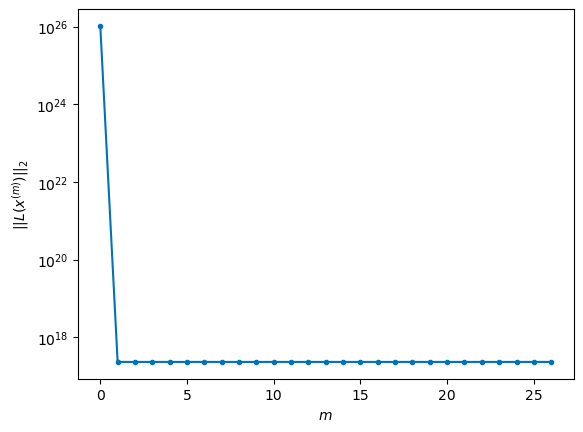

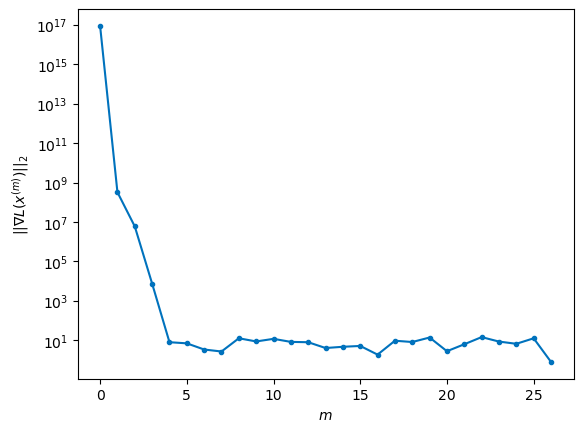

Before applying the algorithm
L_norm = 1.44380887141766e+26
Grad_L_norm = 1.0279795845535637e+17

Iteration 1
L_norm = 2.3435064543893018e+17
Grad_L_norm = 326533340.12235105



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.40422e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.24811e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3435060359659414e+17
Grad_L_norm = 5134232.793809137

Iteration 3
L_norm = 2.3435060357726467e+17
Grad_L_norm = 6494.318015056012



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22306e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22517e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
L_norm = 2.343506035772532e+17
Grad_L_norm = 4.473073763366916

Iteration 5
L_norm = 2.3435060357729773e+17
Grad_L_norm = 2.1523492757888874



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22433e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22468e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 6
L_norm = 2.3435060357727594e+17
Grad_L_norm = 8.608432320510808



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22601e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22432e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 7
L_norm = 2.3435060357728138e+17
Grad_L_norm = 11.734608461013435

Iteration 8
L_norm = 2.3435060357724218e+17
Grad_L_norm = 2.281941886153311

Iteration 9
L_norm = 2.3435060357727683e+17
Grad_L_norm = 3.0906905087408294

Iteration 10
L_norm = 2.3435060357730384e+17
Grad_L_norm = 9.507580071615301



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22546e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2249e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 11
L_norm = 2.3435060357725226e+17
Grad_L_norm = 8.136410454249317

Iteration 12
L_norm = 2.3435060357728662e+17
Grad_L_norm = 3.4142881390471054



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22508e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22421e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 13
L_norm = 2.3435060357724896e+17
Grad_L_norm = 15.187245843691985

Iteration 14
L_norm = 2.343506035772679e+17
Grad_L_norm = 1.6898348793404354



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22491e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.22487e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 15
L_norm = 2.343506035773308e+17
Grad_L_norm = 4.953247281235965

Iteration 16
L_norm = 2.343506035772646e+17
Grad_L_norm = 10.953423029603035



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.2245e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


STOP on Iteration 17
L_norm = 2.3435060357726416e+17
Grad_L_norm = 0.2798832859311704



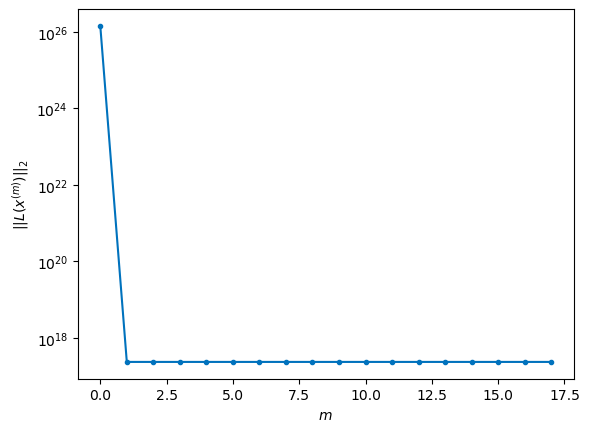

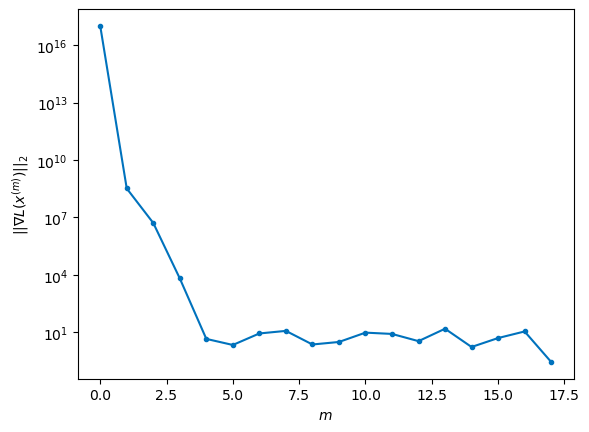

Before applying the algorithm
L_norm = 1.8989120029351628e+26
Grad_L_norm = 1.1790572455362168e+17

Iteration 1
L_norm = 2.3372770331342358e+17
Grad_L_norm = 330914088.037194



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.3704e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.20672e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
L_norm = 2.3372766073320048e+17
Grad_L_norm = 2893680.4597367444

Iteration 3
L_norm = 2.3372766072724938e+17
Grad_L_norm = 1311.6570309783826



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.1914e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19085e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
L_norm = 2.3372766072724154e+17
Grad_L_norm = 3.47682295010893

Iteration 5
L_norm = 2.3372766072721165e+17
Grad_L_norm = 12.022783338765013



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19137e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19082e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 6
L_norm = 2.337276607272207e+17
Grad_L_norm = 6.409011182772375

Iteration 7
L_norm = 2.3372766072724304e+17
Grad_L_norm = 2.21176165482667



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19135e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19152e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 8
L_norm = 2.337276607272398e+17
Grad_L_norm = 5.125307764302943



/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_29381/2269144884.py:38: LinAlgWarning: Ill-conditioned matrix (rcond=4.19078e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


KeyboardInterrupt: 

In [82]:
rmse_1 = []
rmse_2 = []
rmse_3 = []
rmse_4 = []
NKKT_first_round_stop_iteration = []
NKKT_K_minus_W_next_rounds_stop_iteration = []
for m in range(M):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    # Y = np.zeros((n_y_1 + n_y_2 + n_y_3 + n_y_4, 1, K))
    # for k in range(K):
    #     Y[:n_y_1, :, k] = h_1(k, x_initial_1) + np.sqrt(R_1) @ np.random.randn(n_y_1, 1)
    #     Y[n_y_1:n_y_1 + n_y_2, :, k] = h_2(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_2) @ np.random.randn(n_y_2, 1)
    #     Y[n_y_1 + n_y_2:n_y_1 + n_y_2 + n_y_3, :, k] = h_3(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_3) @ np.random.randn(n_y_3, 1)
    #     Y[n_y_1 + n_y_2 + n_y_3:, :, k] = h_4(k, x_initial_1, x_initial_2, x_initial_3, x_initial_4) + np.sqrt(R_4) @ np.random.randn(n_y_4, 1)

    # Before applying the Newton algorithm for the first time, initialize the initial conditions guess randomly (cold-start) 
    x_init = np.zeros((4 * n_x, 1))
    x_init[:4*n_x, :] = X_est[:, :, 0]
    
    # Apply the algorithm
    p_1_est = np.zeros((n_p, 1, K - W + 1))
    p_2_est = np.zeros((n_p, 1, K - W + 1))
    p_3_est = np.zeros((n_p, 1, K - W + 1))
    p_4_est = np.zeros((n_p, 1, K - W + 1))
    for n in range(K - W + 1):
        nkkt = NKKT()
        x_est = nkkt.solve(x_init, STM_t0[:, :, n:n + W], Y[:, :, n:n + W])
        p_1_est[:, :, n] = P @ x_est[:n_x, :]
        p_2_est[:, :, n] = P @ x_est[n_x:2*n_x, :]
        p_3_est[:, :, n] = P @ x_est[2*n_x:3*n_x, :]
        p_4_est[:, :, n] = P @ x_est[3*n_x:, :]
        
        give_me_the_plots(nkkt.i, nkkt.L_norms, nkkt.grad_L_norms)

        if n == 0: # Check divergence in the beginning
            abs_error_init_1 = np.zeros(W)
            abs_error_init_2 = np.zeros(W)
            abs_error_init_3 = np.zeros(W)
            abs_error_init_4 = np.zeros(W)
            for k in range(W):
                abs_error_init_1[k] = np.linalg.norm(P @ SatelliteDynamics().x_new(dt, x_est[:n_x, :]) - P @ X_true[:n_x, :, k])
                abs_error_init_2[k] = np.linalg.norm(P @ SatelliteDynamics().x_new(dt, x_est[n_x:2*n_x, :]) - P @ X_true[n_x:2*n_x, :, k])
                abs_error_init_3[k] = np.linalg.norm(P @ SatelliteDynamics().x_new(dt, x_est[2*n_x:3*n_x, :]) - P @ X_true[2*n_x:3*n_x, :, k])
                abs_error_init_4[k] = np.linalg.norm(P @ SatelliteDynamics().x_new(dt, x_est[3*n_x:, :]) - P @ X_true[3*n_x:, :, k])
            rmse_init_1 = np.sqrt(np.mean(abs_error_init_1 ** 2))
            rmse_init_2 = np.sqrt(np.mean(abs_error_init_2 ** 2))
            rmse_init_3 = np.sqrt(np.mean(abs_error_init_3 ** 2))
            rmse_init_4 = np.sqrt(np.mean(abs_error_init_4 ** 2))
            # if rmse_init_1 > 1e2 or rmse_init_2 > 1e2 or rmse_init_3 > 1e2 or rmse_init_4 > 1e2:
            #     print(f"This Monte Carlo run #{m + 1} diverged!")
            #     # Mimic the propagation for rmse computation below
            #     for k in range(K - W + 1):
            #         p_1_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[:n_x, :])
            #         p_2_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[n_x:2*n_x, :])
            #         p_3_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[2*n_x:3*n_x, :])
            #         p_4_est[:, :, k] = P @ SatelliteDynamics().x_new(dt, x_est[3*n_x:4*n_x, :])
            #     break
            # else:
            #     NKKT_first_round_stop_iteration.append(nkkt.i)
        else:
            NKKT_K_minus_W_next_rounds_stop_iteration.append(nkkt.i)

        # Get next new guess (warm-start)
        # The initial guess is the previous window estimate second timestamp value
        x_init[:n_x, :] = SatelliteDynamics().x_new(dt, x_est[:n_x, :])
        x_init[n_x:2*n_x, :] = SatelliteDynamics().x_new(dt, x_est[n_x:2*n_x, :])
        x_init[2*n_x:3*n_x, :] = SatelliteDynamics().x_new(dt, x_est[2*n_x:3*n_x, :])
        x_init[3*n_x:4*n_x, :] = SatelliteDynamics().x_new(dt, x_est[3*n_x:4*n_x, :])

    # After each Monte Carlo Run compute the RMSE_m for each first K - W + 1 iterations
    abs_error_1 = np.zeros(K - W + 1)
    abs_error_2 = np.zeros(K - W + 1)
    abs_error_3 = np.zeros(K - W + 1)
    abs_error_4 = np.zeros(K - W + 1)
    for k in range(K - W + 1):
        abs_error_1[k] = np.linalg.norm(p_1_est[:, :, k] - P @ X_true[:n_x, :, k])
        abs_error_2[k] = np.linalg.norm(p_2_est[:, :, k] - P @ X_true[n_x:2*n_x, :, k])
        abs_error_3[k] = np.linalg.norm(p_3_est[:, :, k] - P @ X_true[2*n_x:3*n_x, :, k])
        abs_error_4[k] = np.linalg.norm(p_4_est[:, :, k] - P @ X_true[3*n_x:4*n_x, :, k])
    rmse_m_1 = np.sqrt(np.mean(abs_error_1 ** 2))
    rmse_m_2 = np.sqrt(np.mean(abs_error_2 ** 2))
    rmse_m_3 = np.sqrt(np.mean(abs_error_3 ** 2))
    rmse_m_4 = np.sqrt(np.mean(abs_error_4 ** 2))
    print(f'This MC run RMSE for the first {K - W + 1} iterations:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > 0.5 or rmse_m_2 > 0.5 or rmse_m_3 > 0.5 or rmse_m_4 > 0.5:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the first {K - W + 1} iterations for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of NKKT converged with {np.mean(NKKT_first_round_stop_iteration)} iterations on average.')
print(f'The next {K - W} rounds of NKKT converged with {np.mean(NKKT_K_minus_W_next_rounds_stop_iteration)} iterations on average.')

In [ ]:
dev_chief = np.linalg.norm(p_1_est - X_true[:3, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy1 = np.linalg.norm(p_2_est - X_true[6:9, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy2 = np.linalg.norm(p_3_est - X_true[12:15, :, :K - W + 1], axis=0).reshape(-1, 1)
dev_deputy3 = np.linalg.norm(p_4_est - X_true[18:21, :, :K - W + 1], axis=0).reshape(-1, 1)

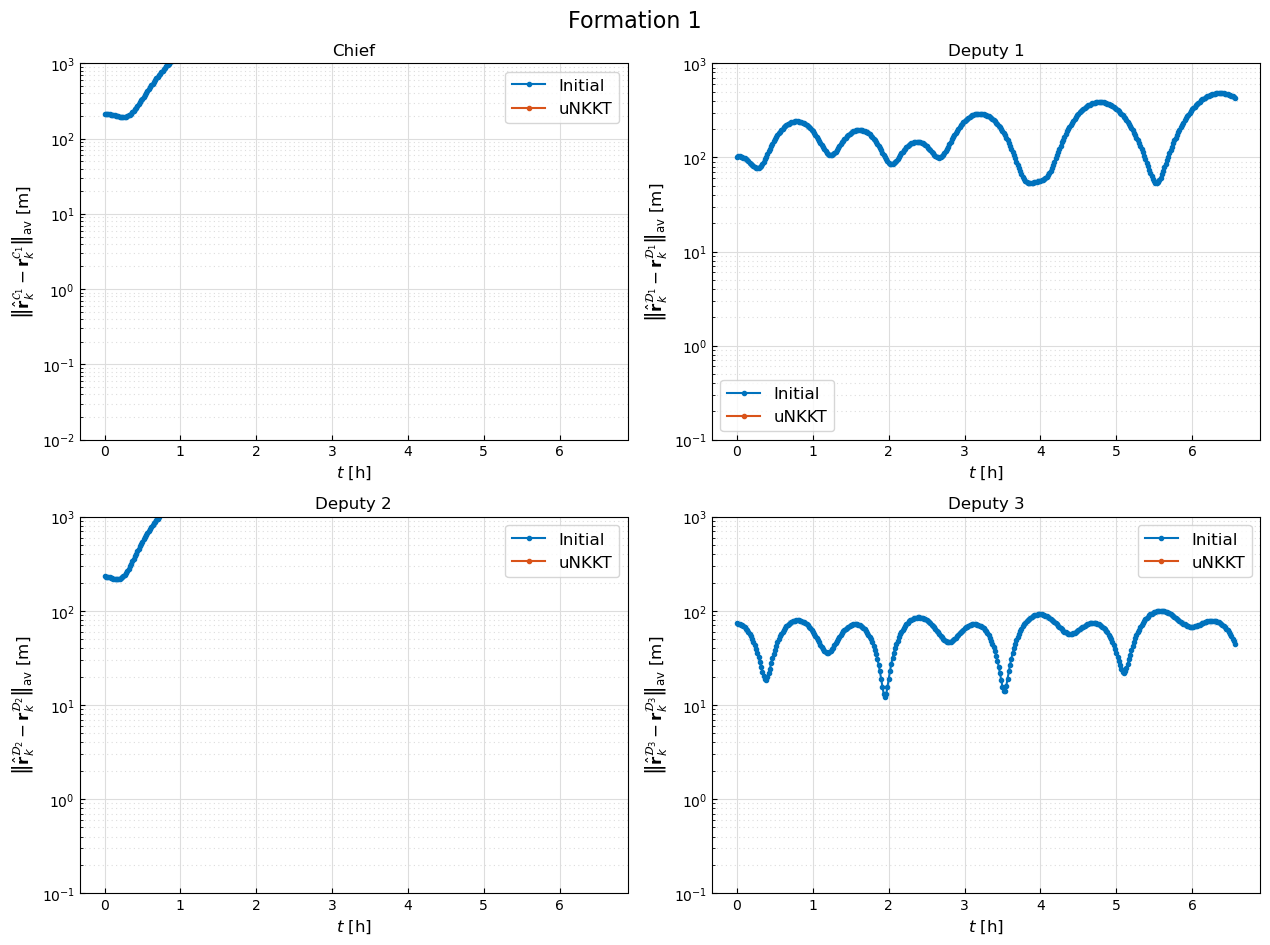

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "uNKKT"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()